## Project Backgound

by Nico Purnomo 04/02/2020

Thanks to https://www.kaggle.com/yufengsui/datacamp-project-mobile-games-a-b-testing and https://www.kaggle.com/ekrembayar/a-b-testing-step-by-step-hypothesis-testing for provoding the data, bsaics steps, and ideas to start on this project.

Cookie Cats is a popular mobile puzzle game created by Tactile Entertaiment. The game is based on the classic "Connect-three" style puzzles where the player has to connect tiles of the same colour to finally connect the board and win the level. Tha game has many diffeent features to make it more interesting including animations of "singing cats". 

The game has its limits in terms of playing time. Players will have to wait for a period of time after finishing a series of different levels (They call this gates). A way to reduce the waiting time is to make an in-app purchase. Not only that the restrioctions drive up revenue, but also it allows players to get an enforced "break" so that the excitement can be prolonged. It is a very interesting technique in which players are forced to wait to be able to play. It is the sense of relief when they are actually able to play that the game is trying to achieve. Games can be addictive and it is a way to make it more desirable in a way so that players do not get bored quickly. 

In this notebook, we are going to look at where to put such "gates" to increase player retention. The data has provided results on player retention and tests where they put the gates at level 30 and level 40.


In [40]:
# Import the relevant libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import os
from scipy.stats import shapiro
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

In [5]:
# Let's look at the data.

df = pd.read_csv("cookie_cats.csv")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


90,189 players installed the game while the AB-test was running. When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. 

The variables are:
<ul>
<li><code>userid</code> - player identification.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the test group (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first week after installation
<li><code>retention_1</code> - binary: did the player come back and play 1 day after installing?</li>
<li><code>retention_7</code> - binary: did the player come back and play 7 days after installing?</li>
</ul>


In [3]:
# Check data.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
# Count number of players in each version (gate_30 and gate_40).

df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


It is good to see that the number of players in each version is rouugly the same at about 44000 to 45000. The number of players is also a pretty good amount to properly do the test. The higher number the better as it would properly sample the population of players. 

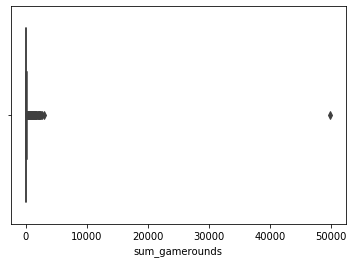

In [11]:
# Visualise the distribution of 'sum_gamerounds' to look at how many game rounds were played by players during the first week after installation.

sns.boxplot(df['sum_gamerounds'])

From the simple boxplot above, we can see from the right side that there is an outlier. This "player" seems to play about 50,000 rounds on the first week. The diagram becomes not so useful. We will remove the outliers later. 

In [43]:
# Making sure that our assumption is correct
df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


In [37]:
# Count the number of players for each number of game rounds

count_round = df.groupby('sum_gamerounds')['userid'].count()
count_round.head(15)

sum_gamerounds
0     3994
1     5538
2     4606
3     3958
4     3629
5     2992
6     2861
7     2379
8     2267
9     2013
10    1752
11    1654
12    1570
13    1594
14    1519
Name: userid, dtype: int64

Let's create a line plot to properly see roughly how many rounds players play in the first week 

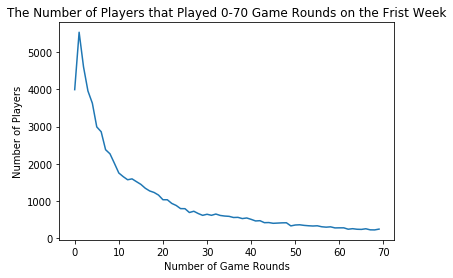

In [36]:
ax = sns.lineplot(data = count_round[:70])
ax.set(xlabel='Number of Game Rounds', ylabel='Number of Players', title='The Number of Players that Played 0-70 Game Rounds on the Frist Week')
plt.show()

The distribution is skewed to the right, meaning that it has a long right tail. A large number of players play fewer than 20 game rounds on the first week of installation. For number of rounds greater than 20, the amount of players decreases slowly from about 1000 players per number of game rounds to about a steady 300s. More research and testing can explain more about user churn.

It is also really interesting to see that about 4000 people downloaded the game withuot playing a single round. This can be because he/she downloaded multiple games at the same time, the player disliked the initial design of the game and opted to not play, or the user decided to install first and play at a later time.

The significant decrease of number of players for increasing game rounds can be a sign of bad retention as players leaave at an early stage. It is understandable that players will try out a few rounds first until they decide to keep on playing ot not.


In [38]:
# We can look at the percentage of players that actually came back and play one day after installation by calcuulating the mean of retention_1

df['retention_1'].mean()

0.4452095044850259

We can see that less than half of all the players who downloaded the game continued on playing after the first day of installation. This can be the benchmark once we look at the different groups (version gate_30 or gate_40)

In [39]:
df.groupby('version')['retention_1'].mean()


version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

There is a slight difference in which gate_30 would give a little increase in retention compared to the test version, gate_40. However, we cannot be sure at first. We will set gate_30, the control as A and gate_40, the test as B.

thanks to https://www.kaggle.com/ekrembayar/a-b-testing-step-by-step-hypothesis-testing 

We can now try to reload data in a fancier manner.

In [41]:
path = "cookie_cats.csv"

def load(path, info = True):
    
    import pandas as pd
    import io
    
    if len(path.split(".csv")) > 1:
        read = pd.read_csv(path)
    elif len(path.split(".xlsx")) > 1:
        read = pd.read_excel(path)
    
    if info:
        if len(read) > 0:
            print("# Data imported!")
            print("# ------------------------------------", "\n")
        
            print("# DIMENSIONS -------------------------")
            print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")
    
            print("# DTYPES -----------------------------")
            if len(read.select_dtypes("object").columns) > 0:
                print("Object Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("object").columns), "\n", 
                      read.select_dtypes("object").columns.tolist(), "\n")
    
            if len(read.select_dtypes("integer").columns) > 0:
                print("Integer Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("integer").columns), "\n", 
                      read.select_dtypes("integer").columns.tolist(), "\n")
    
            if len(read.select_dtypes("float").columns) > 0:
                print("Float Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("float").columns), "\n", 
                      read.select_dtypes("float").columns.tolist(), "\n")
    
            if len(read.select_dtypes("bool").columns) > 0:
                print("Bool Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("bool").columns), "\n", 
                      read.select_dtypes("bool").columns.tolist(), "\n")
    
            print("# MISSING VALUE ---------------------")
            print("Are there any missing values? \n ", np.where(read.isnull().values.any() == False, 
                                                            "No missing value!", "Data includes missing value!"), "\n")
            
            buf = io.StringIO()
            read.info(buf=buf)
            info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
            print("# MEMORY USAGE ---------------------- \n", info)
          
        else:
            print("# Data did not import!")
    
    return read
    
ab = load(path, info = True)
ab.head()

# Data imported!
# ------------------------------------ 

# DIMENSIONS -------------------------
Observation: 90189 Column: 5 

# DTYPES -----------------------------
Object Variables: 
 # of Variables: 1 
 ['version'] 

Integer Variables: 
 # of Variables: 2 
 ['userid', 'sum_gamerounds'] 

Bool Variables: 
 # of Variables: 2 
 ['retention_1', 'retention_7'] 

# MISSING VALUE ---------------------
Are there any missing values? 
  No missing value! 

# MEMORY USAGE ---------------------- 
 2.2+ MB


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [44]:
# A/B Groups & Target Summary Stats
ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17,52.4563,256.7164,49854
gate_40,45489,16,51.2988,103.2944,2640


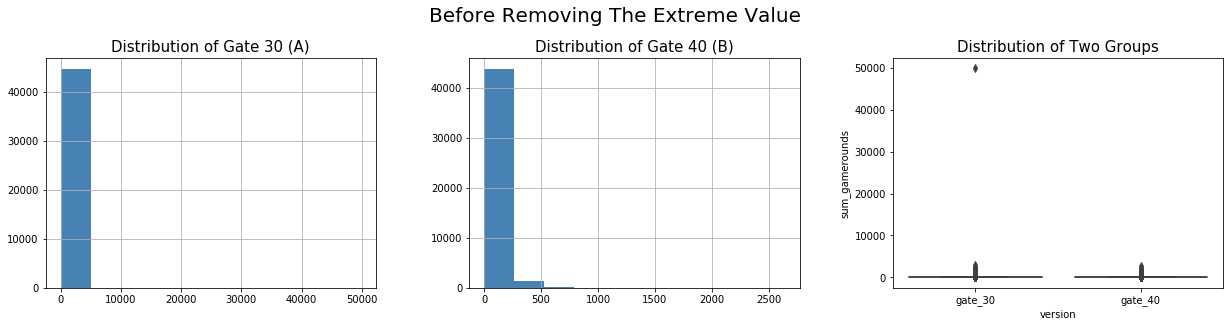

In [45]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
ab[(ab.version == "gate_30")].hist("sum_gamerounds", ax = axes[0], color = "steelblue")
ab[(ab.version == "gate_40")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
sns.boxplot(x = ab.version, y = ab.sum_gamerounds, ax = axes[2])

plt.suptitle("Before Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[1].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[2].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

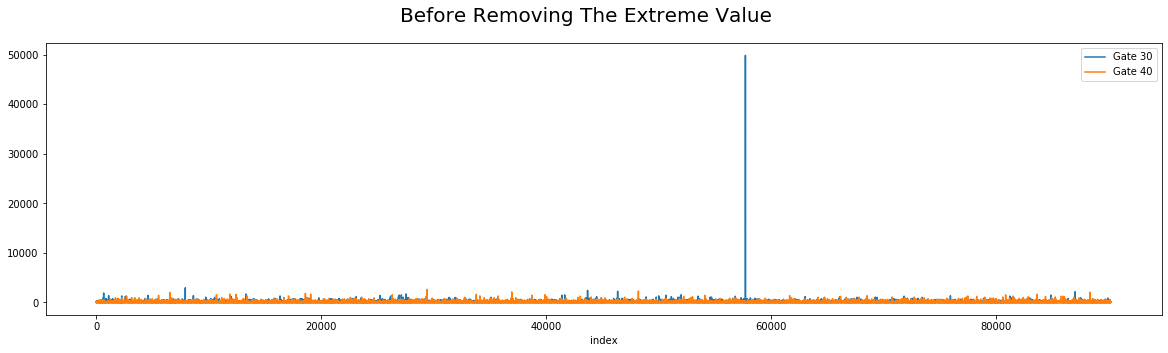

In [46]:
# Let's look at the extreme values from the previous boxplot diagram.
ab[ab.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
ab[ab.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40")
plt.suptitle("Before Removing The Extreme Value", fontsize = 20);

In [47]:
# Remove extreme values by selecting rows only below the maximum sum_gamerounds value
ab = ab[ab.sum_gamerounds < ab.sum_gamerounds.max()]

# Summary Stats: sum_gamerounds
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T 

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0000,51.3203,102.6827,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,2961.0000


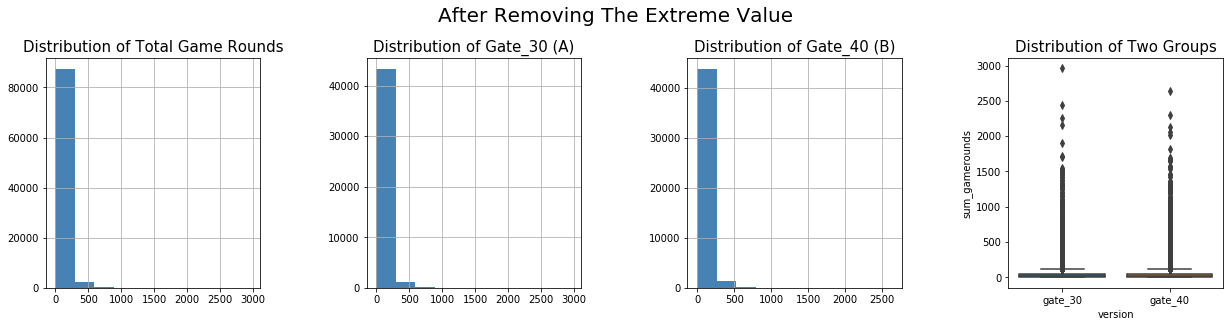

In [49]:
fig, axes = plt.subplots(1, 4, figsize = (18,5))
ab.sum_gamerounds.hist(ax = axes[0], color = "steelblue")
ab[(ab.version == "gate_30")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
ab[(ab.version == "gate_40")].hist("sum_gamerounds", ax = axes[2], color = "steelblue")
sns.boxplot(x = ab.version, y = ab.sum_gamerounds, ax = axes[3])

plt.suptitle("After Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Total Game Rounds", fontsize = 15)
axes[1].set_title("Distribution of Gate_30 (A)", fontsize = 15)
axes[2].set_title("Distribution of Gate_40 (B)", fontsize = 15)
axes[3].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

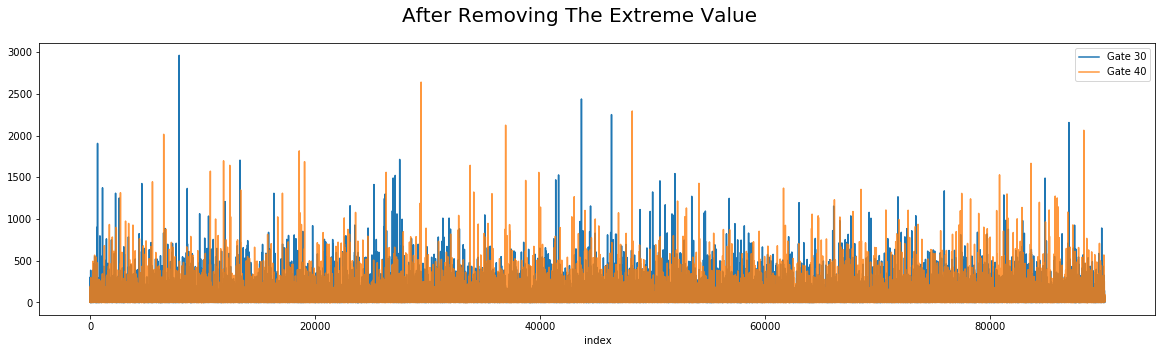

In [57]:
ab[ab.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
ab[ab.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40", alpha = 0.8)
plt.suptitle("After Removing The Extreme Value", fontsize = 20);

In [59]:
df['retention_1'].mean()

0.4452095044850259

In [60]:
# Retention stats. False would mean that they quit the game after the listed period.
pd.DataFrame({"RET1_COUNT": ab["retention_1"].value_counts(),
              "RET7_COUNT": ab["retention_7"].value_counts(),
              "RET1_RATIO": ab["retention_1"].value_counts() / len(ab),
              "RET7_RATIO": ab["retention_7"].value_counts() / len(ab)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50035,73408,0.5548,0.8139
True,40153,16780,0.4452,0.1861


In [61]:
ab.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])


count  median    mean      std   max
version retention_1                                      
gate_30 False        24665       6 16.3591  36.5284  1072
        True         20034      48 94.4117 135.0377  2961
gate_40 False        25370       6 16.3404  35.9258  1241
        True         20119      49 95.3812 137.8873  2640

In [63]:
ab.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median     mean      std   max
version retention_7                                       
gate_30 False        36198      11  25.7965  43.3162   981
        True          8501     105 160.1175 179.3586  2961
gate_40 False        37210      11  25.8564  44.4061  2640
        True          8279     111 165.6498 183.7925  2294

In [64]:
# Final check of retention by looking at players who play the day after and a week after installation.
ab["Retention"] = np.where((ab.retention_1 == True) & (ab.retention_7 == True), 1,0)
ab.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count  median     mean      std   max
version Retention                                       
gate_30 0          38023      12  28.0703  48.0175  1072
        1           6676     127 183.8863 189.6264  2961
gate_40 0          38983      12  28.1034  48.9278  2640
        1           6506     133 190.2824 194.2201  2294

From the above results, we cannot really tell the difference between both versions as they are really similar. About 13,000 players who played the day after and continued on playing 7 days after installing. That is about 14% of the total players in this dataset. This seems to be a lower than average number in the industry according to https://thetool.io/2018/user-retention-mobile-apps-games.

### Proper A/B Testing 

Now we will do a proper test with steps as follows:
- First, split control and test group. This will be the 2 versions (gate_30 and gate_40)
- Check normality with Shapiro Test
- If Normal distribution, check homogeneity with Levene Test of Variances
- If Parametric and homogenous, use T-Test
- If Parametric and heterogenous, use Welch Test
- If Non-Parametric, use Mann Whitney U Test





In [65]:
# Split A/B groups and check.
ab["version"] = np.where(ab.version == "gate_30", "A", "B")
ab.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention
0,116,A,3,False,False,0
1,337,A,38,True,False,0
2,377,B,165,True,False,0
3,483,B,1,False,False,0
4,488,B,179,True,True,1


In [66]:
# A/B Testing Function 
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    

In [68]:
# Use the above function
AB_Test(dataframe=ab, group='version', target='sum_gamerounds')

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.0254,A/B groups are not similar!


## Conclusion

Players progress through the game and will encounter such gates that will make them wait or make in app-purchases. In this notebook, we have analysed the dataset and did an A/B test where the gates are changed to level 40 from level 30. This means that players are allowed to clear more rounds before they run into the gate that would stop them from playing. 

After rejecting the normality test, we used the non-parametric test, Mann Whitney U, to compare the 2 groups (gate_30 and gate_40). The result has shown that we are able to reject the null hypothesis (H0) and say that A/B groups are different at 5% significance level. Therefore, we can say that there is a statistically significant difference between the two groups for the number of gamerounds that the players play. 

This makes sense as we have stated earlier that players are allowed to clear more rounds before the gate is introduced at level 40 for players with the test version. We would then suggest Tactile Entertaiment to change the gate level to 40 for every user to let players go further into the game and feel more connected to it.

### Next Steps

I think that it would be amazing if we can make use of more features to look deeper on the retention rate as it is really important and would also increase the number of rounds that the players play. Another aspect is the number of in app-purchases that players actually make as it is one of the revenue streams for the company. We can then analyse players who actually make the purchases and try to look for potential players and finally make use of targeted ads. 